# Prioritizing targets with TSM and expected total exposure time
This adaptation of Nicholas' prioritization code is essentially the same as found in the Priority-Tools-Tutorial notebook, but there is a slight change to the prioritization ranking, motivated by a need to integrate the SC3-Atmospheres prioritization scheme with Ashley Chontos' algorithm and incorporate suggestions from Ian Crossfield. **Instead of sorting the targets in each bin by the TSM value (see [Kempton et al. 2018](https://arxiv.org/abs/1805.03671)), and then sorting the top three in TSM by their $V$ magnitude, we sort the bins by the ratio of their TSM and the total estimated exposure time needed on HIRES to achieve a 5-$\sigma$ mass, $t_\mathrm{HIRES}$**:

\begin{align}
X & \equiv \frac{\mathrm{TSM}}{t_\mathrm{HIRES}}.
\end{align}

$t_\mathrm{HIRES}$ is a function of the target's $V$ magnitude, a **chosen** number of exposure meter counts (in thousands), $n_\mathrm{counts}$, and the planet's radius, $R_\mathrm{pl}$ (which is used in the empirical mass-radius relation from [Chen & Kipping 2017](https://arxiv.org/abs/1603.08614)):

\begin{align}
t_\mathrm{HIRES} & = t_\mathrm{ob}(V, n_\mathrm{counts}) \times N_\mathrm{obs}(n_\mathrm{counts}, R_\mathrm{pl}) \\
& = t_\mathrm{ob}(V, n_\mathrm{counts}) \times \Big(\frac{5 \cdot \sigma(n_\mathrm{counts})}{K(R_\mathrm{pl})}\Big)^2,
\end{align}
where $t_\mathrm{ob}$ is the exposure time (in seconds) of a single observation, $N_\mathrm{obs}$ is the number of observations needed to achieve the 5-$\sigma$ mass measurement, $\sigma$ is the typical velocity uncertainty (in m/s) on a single RV measurement, and $K$ is the estimated semi-amplitude of the planetary radial velocity signal (in m/s). Functional dependencies are noted in parentheses following dependent variables.

The equation for $N_\mathrm{obs}$ is taken from the equation on page 19 of [Plavchan et al. 2015](https://arxiv.org/abs/1503.01770). $\sigma$ is **roughly** converted from exposure meter counts to velocity precision using https://caltech-ipac.github.io/hiresprv/performance.html.

A larger $X$ value $\rightarrow$ higher priority.

*An example of why the two ranking methods may assign different priorities could be...* Suppose TOI-A and TOI-B have the same TSM value, but TOI-B is brighter in $V$ than TOI-A. In the previous prioritization scheme, TOI-B would be given a higher priority than TOI-A. Suppose the expected K-amplitude of the planetary signal is larger for TOI-A, though, because e.g. the planet is expected to be more massive based on the Chen & Kipping mass-radius relation. This **might** give TOI-A a smaller $t_\mathrm{HIRES}$ value making, it a higher priority than TOI-B in this ranking scheme.

In [23]:
# Load necessary packages and tools

# Data/analysis
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100 # See all of the columns when DFs are displayed

# Util functions
from priority_tools import * # Implementation details and comments can be found in this file

# Plotting (with fancy font/backend output)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high quality figures

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Do some initial data loading, cleaning

In [24]:
# Code in this cell taken from Nicholas

# Generate the key names for all the TOI+ columns we need.
# See column_key_names.txt for what these are
rp_key,ms_key,pp_key,Ts_key,ars_key,Jmag_key,\
    Vmag_key,rs_key,dec_key,Fp_key,mp_key,\
    mp_units,id_key = tess_colnames()

# Load the TOI+ list
toiplus = pd.read_csv('data/toi/toi+-2020-02-20.csv',
                      delimiter=',',header=4)

# Load the TIC star info
TIC_info = pd.read_csv('data/exofop/TIC_star_info_2020-02-20.csv',
                       delimiter=',',header=10)

# Run the data cleaning function 
tess = clean_tess_data(toiplus, TIC_info, include_qlp=False)

# Load the known planets (and Kepler PCs) table, and merge it
kps = pd.read_csv(r'data/kp-k14_pc-v14.csv')
df = tess.append(kps[np.logical_and(kps['K_amp'] > 1.5, kps['TSM'] > 10)],sort=False) 
    # The K_amp cut wasn't made in the data itself, but is 
    # necessary to cut some of those not-real long-period
    # KOIs as well as known planets for which we can't get masses
print("This dataframe has {} rows.".format(len(df)))

This dataframe has 1188 rows.


### Calculate $t_\mathrm{HIRES}$ for each entry in the dataframe

In [25]:
# Setting n_counts by hand to 250k for every target right now, but this should be changed in the future,
# since targets can get away with lower exposure meter counts based on e.g. their V mag. 
# - Joey, 03/22/20

# Maybe it's alright to leave it at 250k, since it's just a relative estimate of the exposure time i.e.
# "This is what the exposure time would be *if* we had 250k on the counts for every observation."
n_counts = 250
df['t_HIRES'] = t_HIRES(df['V mag'], n_counts, df['K_amp'])
df['X'] = df['TSM']/df['t_HIRES']

In [26]:
# Get a sense of what information this dataframe has
df.head()

,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,t_HIRES,X
0,spoc,236887394.0,1465.01,303.381740,65.162081,11.84780,0.006100,1766.006690,0.000222,1.420035,0.000025,1.616557,0.018567,24055.374561,186.915340,17,Qatar-1 b,4.57248,0.082846,1.0,0.768108,0.045256,12.392370,0.739193,1251.948474,4910.0,108.354,580.586351,136.635350,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,0.803438,103.637487,6.436608,68.343847,236887394.0,303.381870,65.162331,12.692,10.999,10.527,10.409,309.198571,NaN,31.033581,9.963355
1,spoc,427654774.0,1474.01,349.287339,70.190021,14.14310,0.007508,1765.042474,0.003388,5.222621,0.001436,4.693629,0.613360,15867.992018,2007.716000,17 18,Likely EB; 3-sigma centroid offset towards ano...,4.95337,0.008643,1.0,0.275946,0.008483,3.721602,0.381201,329.650849,3453.0,157.000,2.790858,8.069622,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,0.249256,13.408967,28.898774,12.500258,427654774.0,349.289072,70.190576,16.502,12.710,12.171,11.928,84.255469,NaN,31002.221477,0.002718
2,spoc,237086564.0,1466.01,307.395886,61.550433,11.02780,0.006000,1766.255274,0.002566,1.871529,0.000393,1.643889,0.385031,1110.419780,106.224106,17,NaN,4.50790,0.110712,1.0,0.749646,0.071322,2.491658,2.504803,997.456843,4201.0,125.587,233.936214,10.331200,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,0.659539,6.779299,7.423079,4.650963,237086564.0,307.396532,61.550725,12.189,9.957,9.341,9.196,56.896330,NaN,4216.430343,0.013494
3,spoc,240968774.0,1467.01,19.113929,49.233780,10.59770,0.007301,1766.983728,0.002812,5.973384,0.001413,1.605698,0.753235,1373.411277,166.743070,17,centroid offset towards a 20 mag star,4.74552,0.007707,1.0,0.490737,0.014515,1.827003,2.407974,525.913556,3834.0,157.000,18.079169,8.569228,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,0.488479,4.000472,22.240393,2.277148,240968774.0,19.114644,49.233138,12.293,9.380,8.791,8.568,61.002188,NaN,19357.453706,0.003151
4,spoc,431514478.0,1475.01,357.001182,49.790535,8.77994,0.006100,1767.618296,0.001783,8.495351,0.001270,0.906055,0.487170,718.486945,96.261400,17,Significant scattered light; only two transits...,4.29876,0.063938,1.0,1.880160,0.050161,5.296170,5.259954,1813.345207,10012.0,185.641,2555.306247,8.222785,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,2.563170,24.428101,12.756976,4.094757,431514478.0,357.001275,49.790533,8.790,8.695,8.708,8.687,71.521441,NaN,237.670059,0.300927


### Group all of the targets by bins in planet radius, insolation flux, and stellar effective temperature, and rank them according to the two different methods

In [27]:
# Code in this cell is adapted from code written by Nicholas

# Defining the bins:
# Log-uniform in radius and Fp, uniform in Teff. Right now, 
# you need 6 bin edges for radius and Fp and 4 for Teff; 
# we can change that by editing the "labels" in binning_function
rad_bins = 10**(np.linspace(0,1,6)) 
rad_bins[-1] = 11.2 #want to include up to Jupiter radius 
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

# The two different ranking methods:
# Sort things by TSM and then sort the top three in TSM by their Vmag
binned_TSM_Vmag_df = binning_function(df, bins)

# Sort things by the ratio of TSM and the total exposure time needed to get a 5-sigma mass
binned_X_df = binning_function_X(df, bins)

### Let's see if any of the prioritizations have actually changed between the two methods

In [28]:
# Cut down on some of the extraneous columns
useful_cols = ['Full TOI ID', rp_key, pp_key, Ts_key, Fp_key, 
               'Planet Equilibrium Temperature (K) Value', 'V mag','K_amp', 'TSM', 't_HIRES', 'X']
compare_df = pd.DataFrame()
compare_df[useful_cols] = binned_TSM_Vmag_df[useful_cols]
compare_df['TSM_Vmag_priority'] = binned_TSM_Vmag_df['priority']
compare_df['X_priority'] = binned_X_df['priority']

# Look at the rows where the two methods give different priority rankings
compare_diff_df = compare_df[compare_df['TSM_Vmag_priority'] != compare_df['X_priority']]

In [29]:
# Let's take a look
compare_diff_df

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                      
1          2         1               L 98-59 d             1.570000   
                     1            LTT 1445 A b             1.380000   
           3         1              LHS 3844 b             1.303000   
                     1                GJ 357 b             1.217000   
           4         1                 1442.01             1.109103   
...                                        ...                  ...   
5          4         2               K07415.01            10.970000   
                     2              HAT-P-26 b             7.062000   
                     3              WASP-166 b             7.062000   
                     3                 1135.01             9.001699   
                     3                 1273.01            11.109674   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
1          2         1                        7.450860   
                     1                        5.358820   
           3         1                        0.462929   
                     1                        3.930720   
           4         1                        0.409056   
...                                                ...   
5          4         2                        1.291964   
                     2                        4.234520   
                     3                        5.443540   
                     3                        8.028020   
                     3                        4.631438   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
1          2         1                                 3367.0   
                     1                                 3337.0   
           3         1                                 3036.0   
                     1                                 3505.0   
           4         1                                 3328.0   
...                                                       ...   
5          4         2                                 4995.0   
                     2                                 5079.0   
                     3                                 6050.0   
                     3                                 5962.7   
                     3                                 5736.0   

                                  Effective Stellar Flux Value  \
radius_bin insol_bin st_Teff_bin                                 
1          2         1                                4.333919   
                     1                                5.952523   
           3         1                               70.958115   
                     1                               13.504002   
           4         1                              207.032635   
...                                                        ...   
5          4         2                              572.640000   
                     2                              159.453874   
                     3                              433.746462   
                     3                              246.909698   
                     3                              358.963290   

                                  Planet Equilibrium Temperature (K) Value  \
radius_bin insol_bin st_Teff_bin                                             
1          2         1                                                 NaN   
                     1                                                 NaN   
           3         1                                                 NaN   
                     1                                                 NaN   
           4         1                                          967.452056   
...                                                                    ...   
5          4         2     

Note to myself: So we see that a small number of targets (69 out of ~1200) have different priority levels. Though, it's interesting that, after checking, no targets that were previously unranked by one method became ranked by the other. I wouldn't expect this right away, but maybe it's not so surprising. - Joey, 03/22/20

### Let's visualize the targets that received different priority values


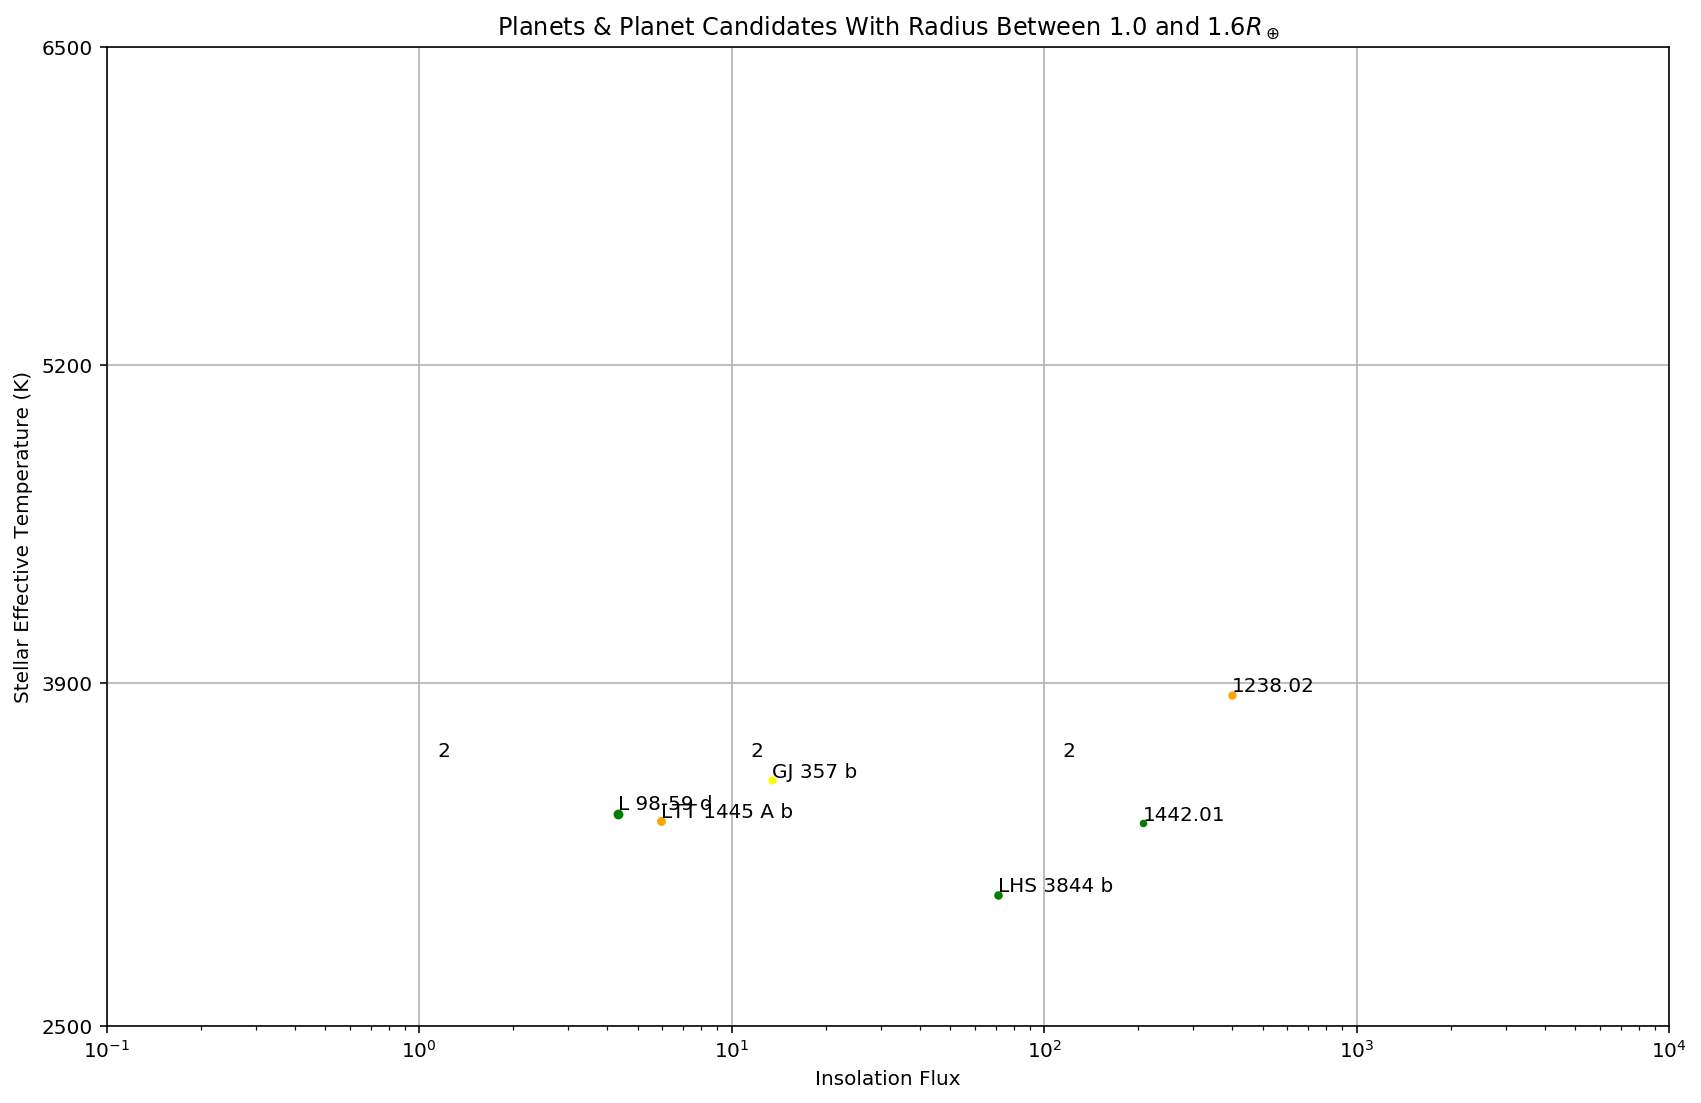

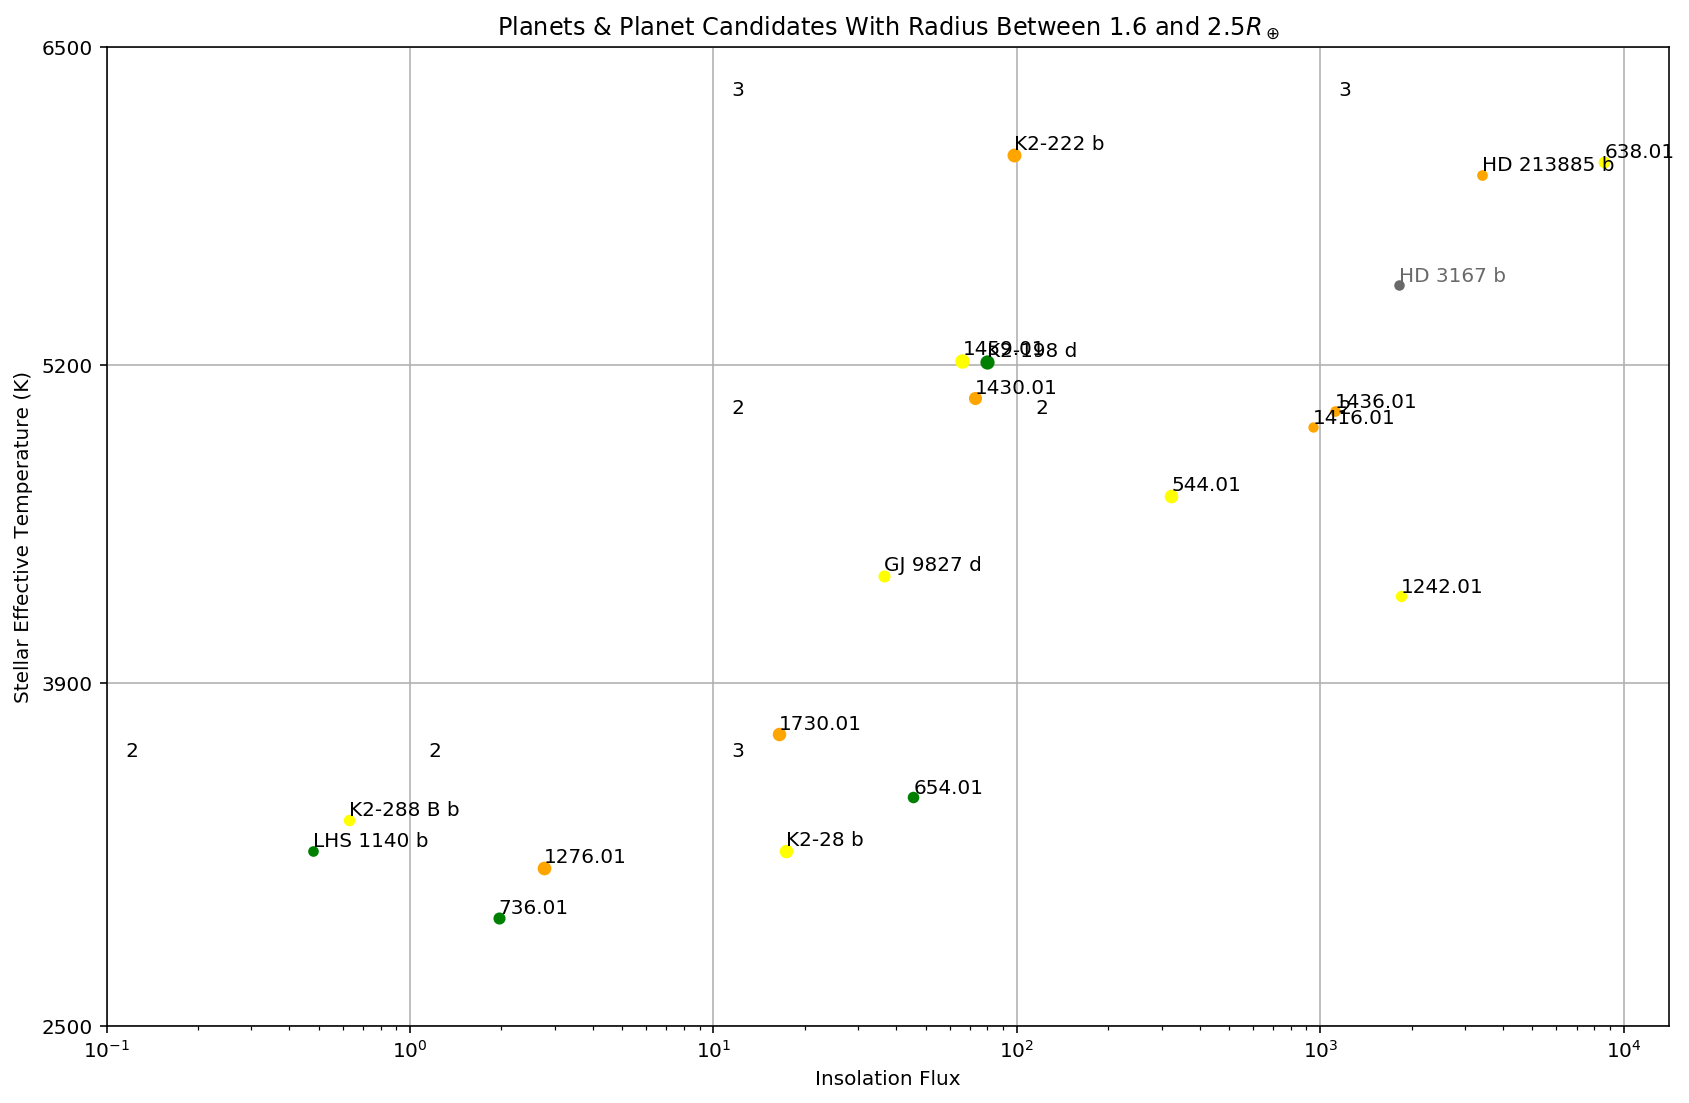

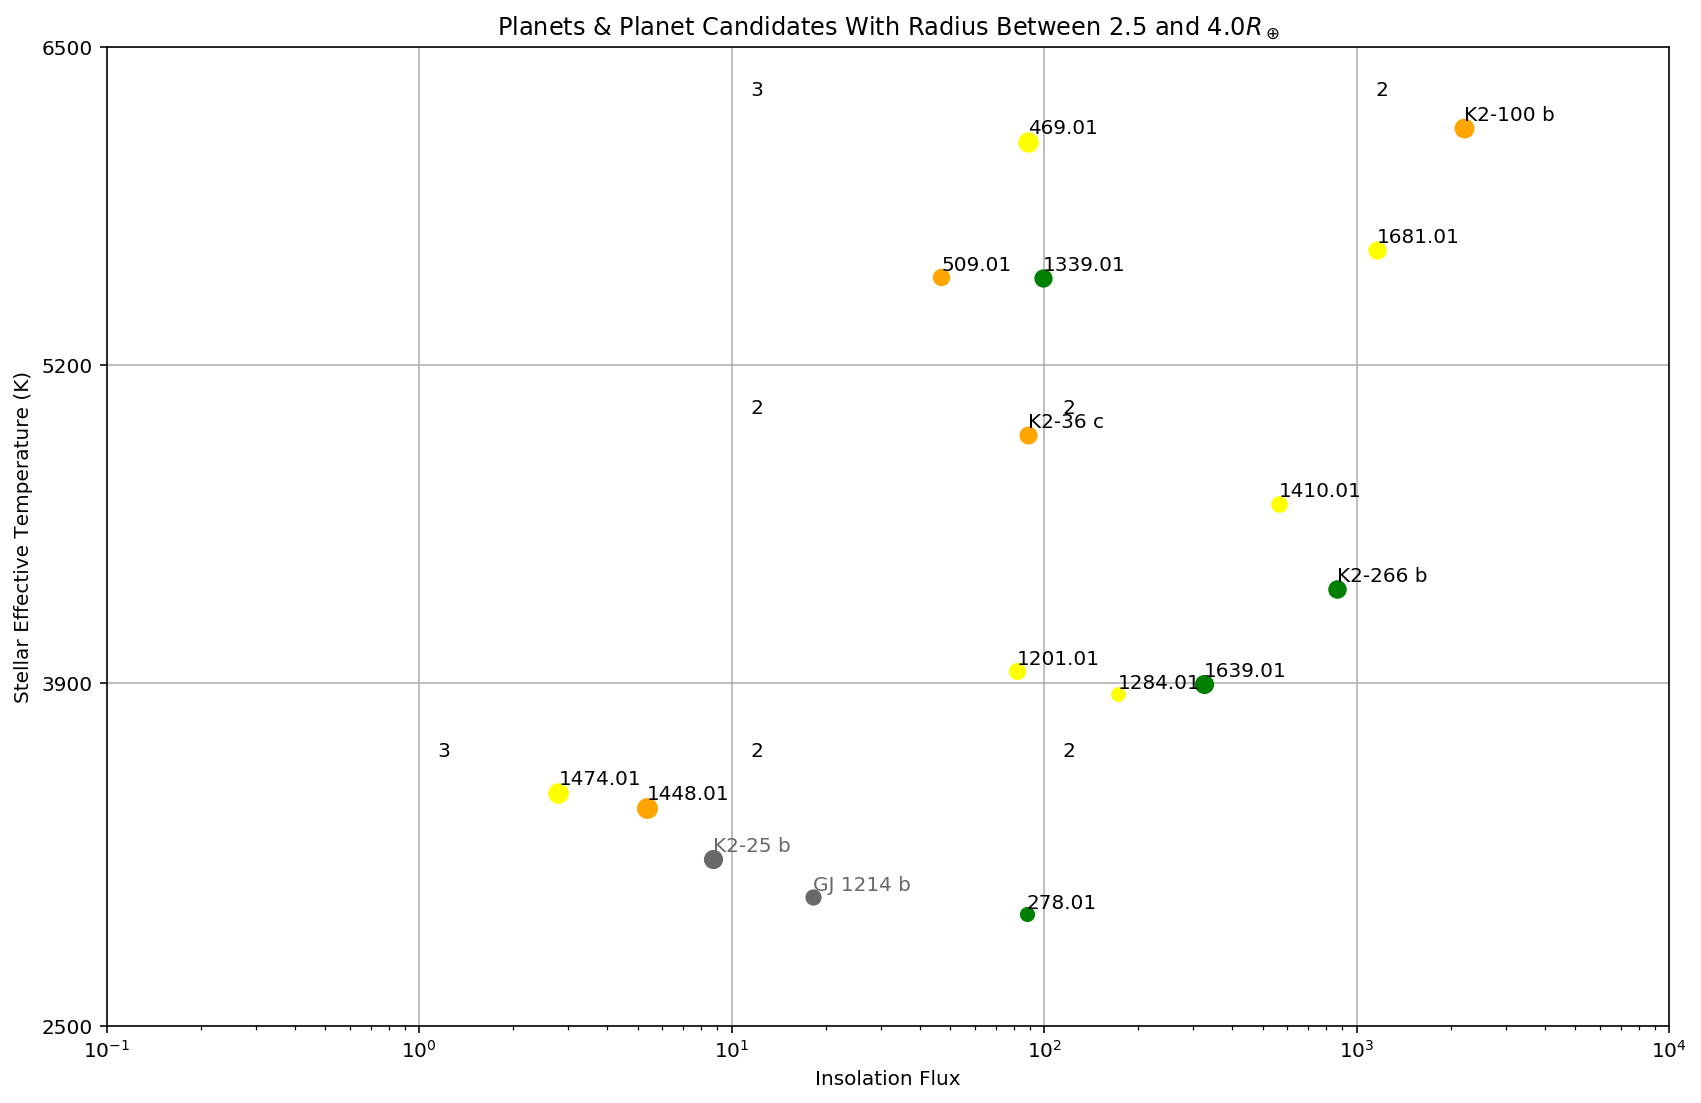

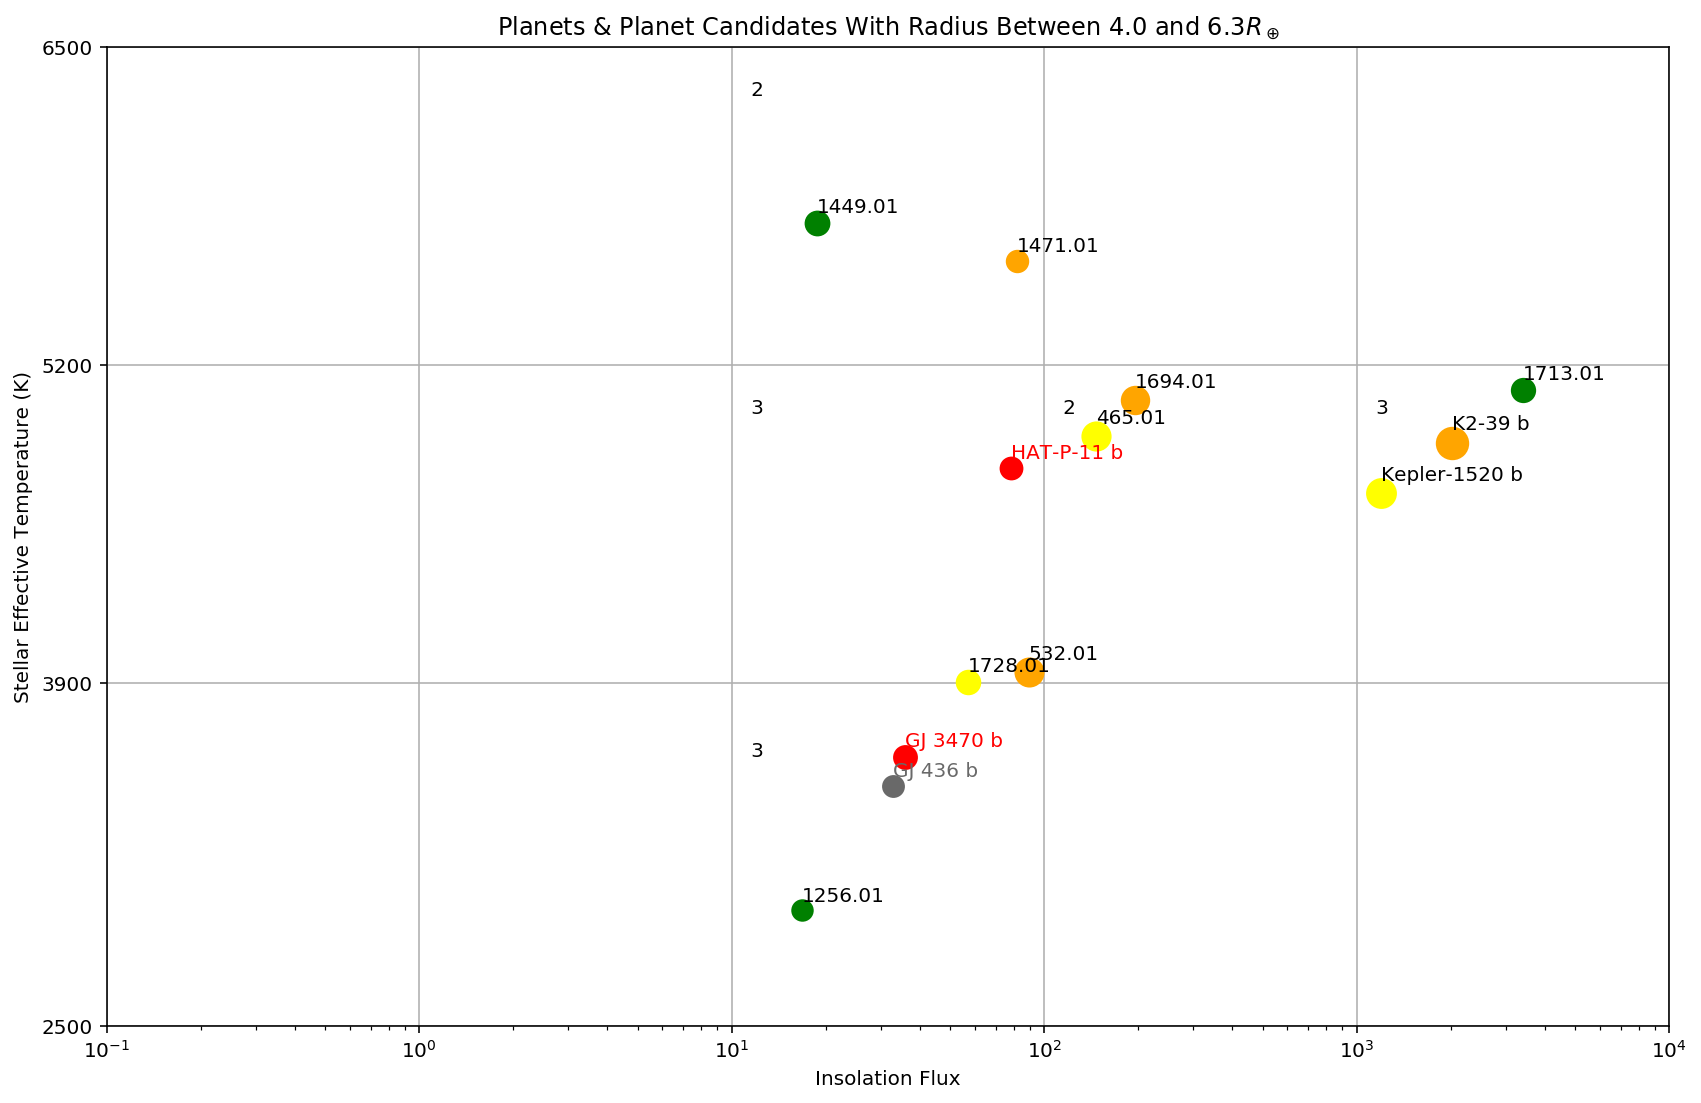

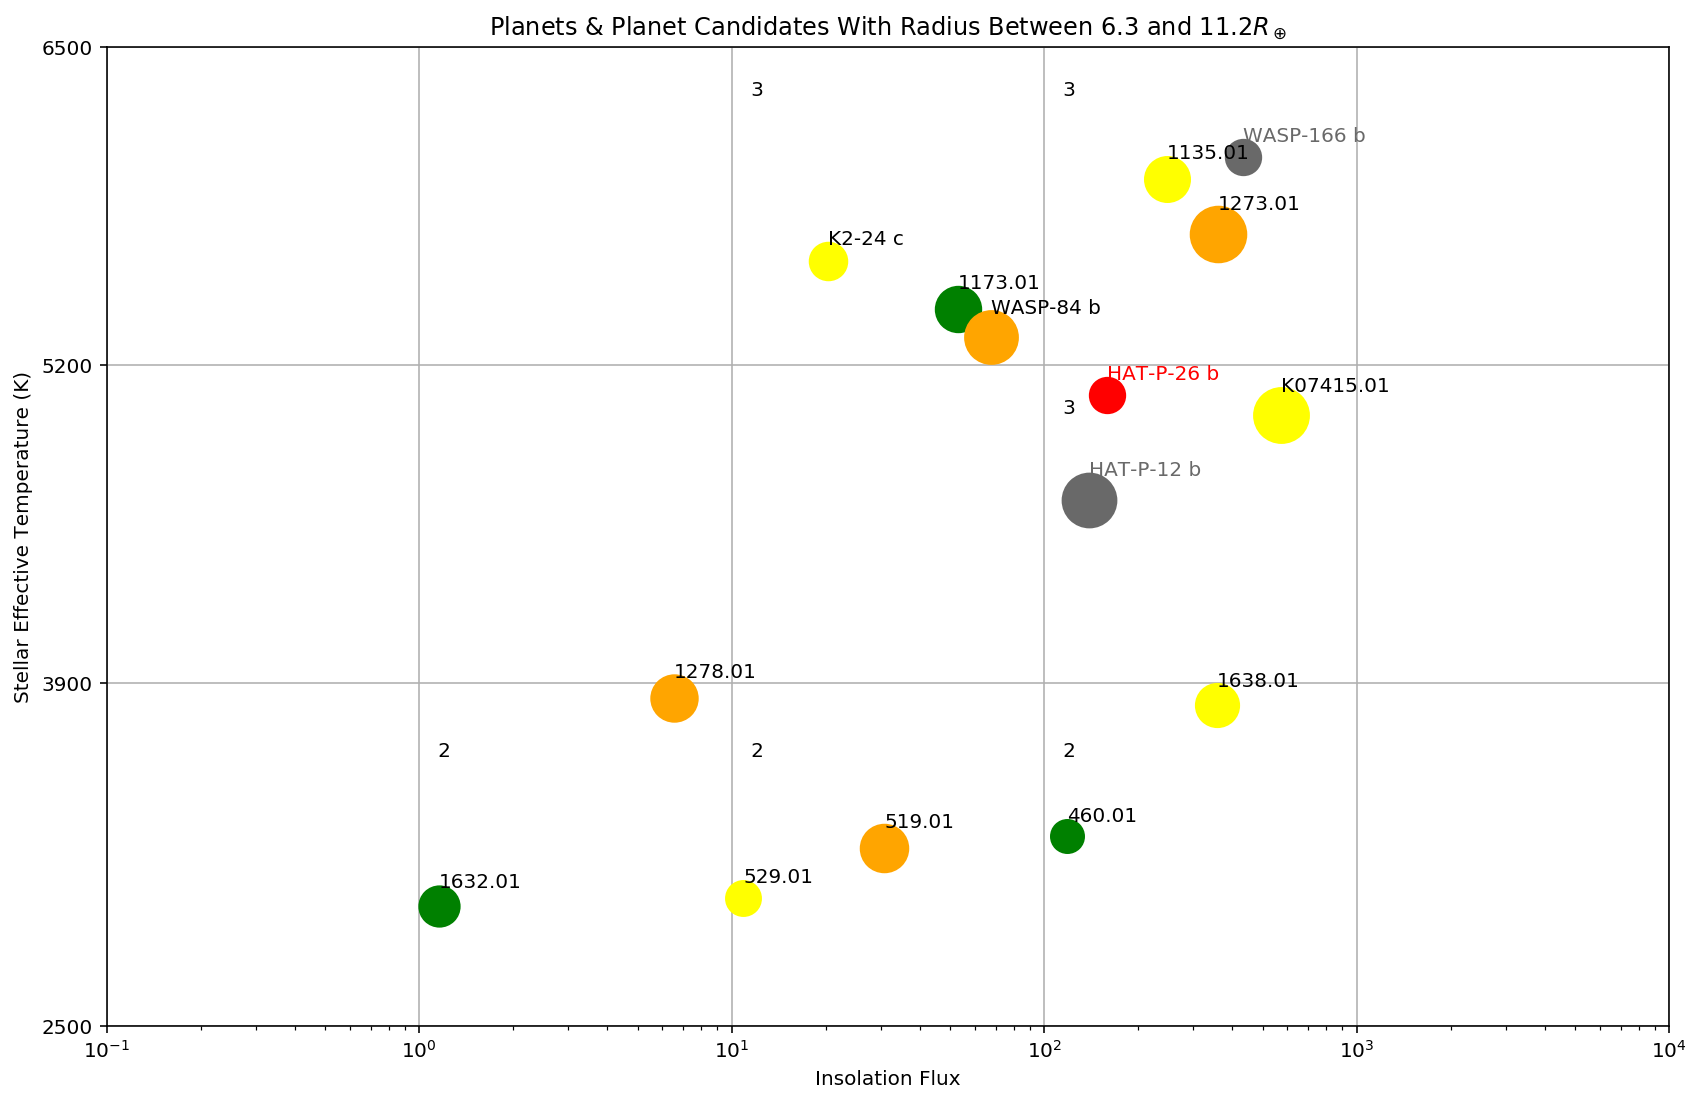

In [30]:
# Code in this cell adapted from Nicholas
for i in np.arange(1,6):
    bin_plotter(compare_diff_df.rename(columns={'X_priority':'priority'}),bins,i)

### Let's plot the X metric as a function of different variables

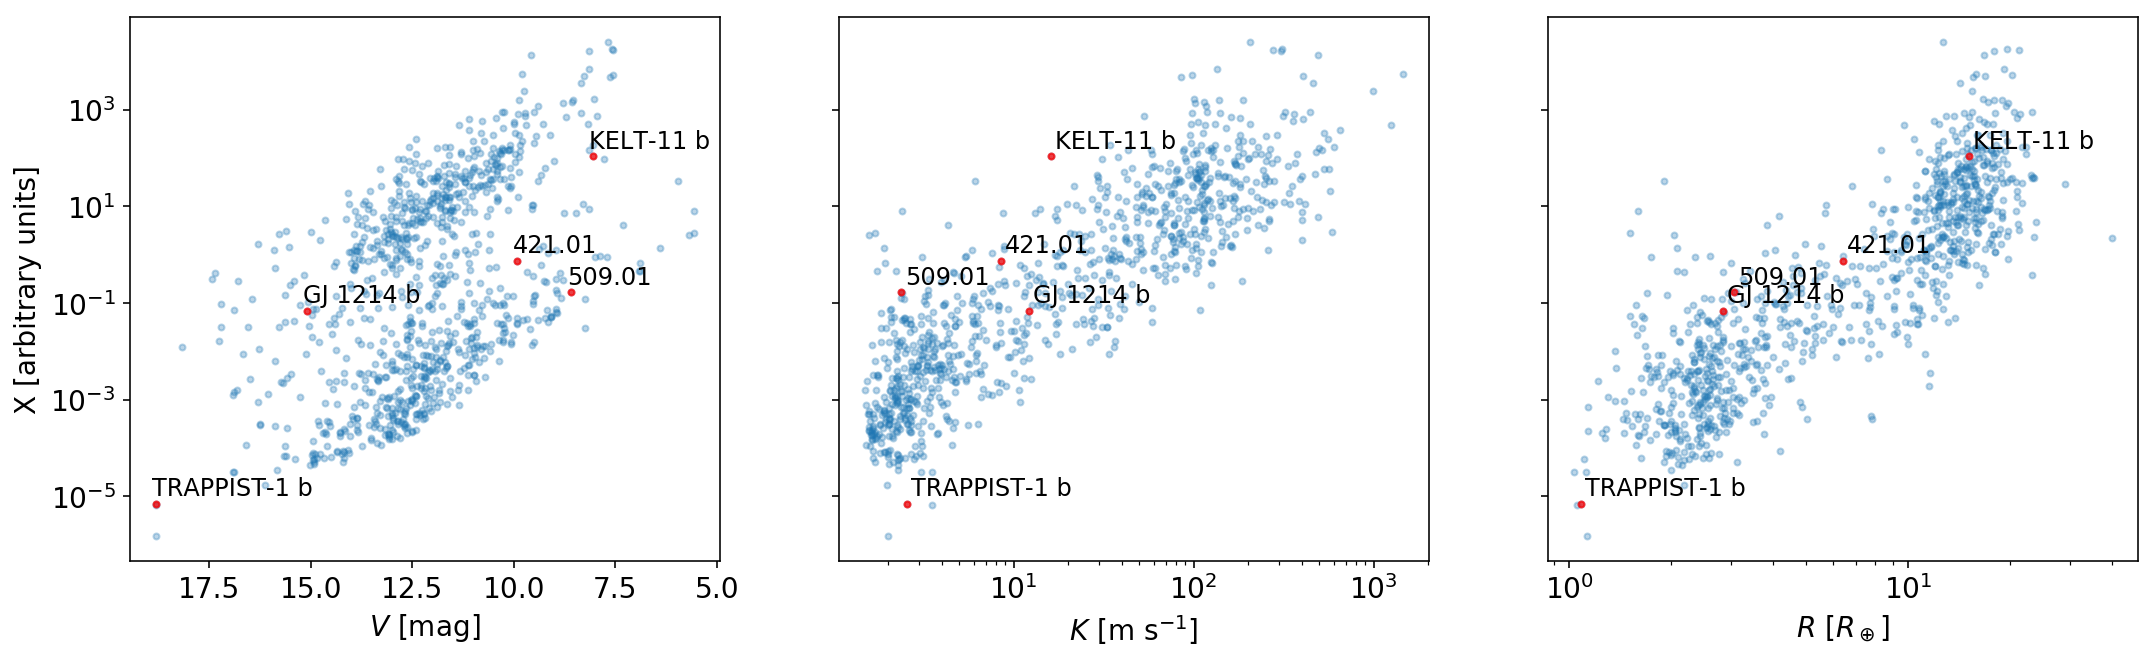

In [31]:
benchmark_planets = ['GJ 1214 b', 'KELT-11 b', 'TRAPPIST-1 b', 509.01, 421.01] 
# Additional benchmark systems may include... [561.01, 1136.01, 1728.01]

def plot_benchmark_planets(planet_list):
    for planet in planet_list:
        curr_row = df[df['Full TOI ID'] == planet]
        
        if type(planet) != str:
            planet = str(planet)
        
        ax_vmag.plot(curr_row['V mag'].values, curr_row['X'].values, '.', color='red', alpha=0.7)
        ax_vmag.text(curr_row['V mag'].values[0] + 0.1, curr_row['X'].values[0] * 1.5, planet, fontsize=12)
        
        ax_kamp.plot(curr_row['K_amp'].values, curr_row['X'].values, '.', color='red', alpha=0.7)
        ax_kamp.text(curr_row['K_amp'].values[0] * 1.05, curr_row['X'].values[0] * 1.5, planet, fontsize=12)
        
        ax_rad.plot(curr_row['Planet Radius Value'].values, curr_row['X'].values, '.', color='red', alpha=0.7)
        ax_rad.text(curr_row['Planet Radius Value'].values[0] * 1.025, curr_row['X'].values[0] * 1.5, planet, fontsize=12)

fig, axes = plt.subplots(figsize=(18,5), ncols=3, sharey=True)
ax_vmag, ax_kamp, ax_rad = axes.flatten()

# Plot as a function of V magnitude
ax_vmag.plot(df['V mag'], df['X'], '.', alpha=0.3)
vmag_low, vmag_high = ax_vmag.get_xlim()
ax_vmag.set_xlim([vmag_high, vmag_low]) # Invert x axis
ax_vmag.set_xlabel('$V$ [mag]', fontsize=14)

# Plot as a function of K-amplitude
ax_kamp.plot(df['K_amp'], df['X'], '.', alpha=0.3)
ax_kamp.set_xlabel('$K$ [m s$^{-1}$]', fontsize=14)

# Plot as a function of radius (though I think this is the same information as K-amplitude)
ax_rad.plot(df['Planet Radius Value'], df['X'], '.', alpha=0.3)
ax_rad.set_xlabel('$R$ [$R_\oplus$]', fontsize=14)

# Mark some notable planets for context
plot_benchmark_planets(benchmark_planets)

# Log scales needed to see structure
ax_vmag.set_yscale('log')
ax_kamp.set_xscale('log')
ax_rad.set_xscale('log')

# Plot housekeeping
ax_vmag.set_ylabel(r'X [arbitrary units]', fontsize=14)
ax_vmag.tick_params(axis='both', labelsize='14')
ax_kamp.tick_params(axis='x', labelsize='14')
ax_rad.tick_params(axis='x', labelsize='14')

plt.show()

## There are a few more things to do...
- What is a good way to make this a global metric? If you were to sort the entire target list just by this $X$ ratio, then clearly the planets that are the biggest and around the brightest stars would be ranked at the top, but they're not always that interesting.
- How to properly sample over parameter space so that we're getting an even spread of targets?
- What is a good method for picking the number of exposure meter counts per target, e.g. is it a function of V mag and K_amp? If we had a function to do this, then we would be able to pick the exposure meter counts for targets more precisely, whereas in this notebook we just used 250k for everything.
- Is there a way we can calculate the velocity precision expected from the exposure meter counts instead of just using the velocity precision figure here: https://caltech-ipac.github.io/hiresprv/performance.html ???
- As a follow-up to above question, for targets that already have observations on Jump, we should measure $\sigma$ directly from their RVs.
- Also, should we ourselves adjust t_HIRES if the target already has some observations? Or should we leave it as the total time, and let Ashley's code handle that? Does her code handle that?

Joey, 03/22/20